In [14]:
import pandas as pd
import numpy as np

In [15]:
df = pd.read_csv('bank-full.csv', sep=";")


In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [17]:
NUMERICAL_COLUMNS = [
    'age',
    'balance',
    'day',
    'duration',
    'campaign',
    'pdays',
    'previous',
]

CATEGORICAL_COLUMNS = [
    'job',
    'marital',
    'education',
    'housing',
    'contact',
    'month',
    'poutcome',
]

USEFUL_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS

TARGET_COLUMN = 'y'

df = df[USEFUL_COLUMNS + [TARGET_COLUMN]]
df['y'] = df['y'].map({'yes': 1, 'no': 0})

df.head(5)

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,housing,contact,month,poutcome,y
0,58,2143,5,261,1,-1,0,management,married,tertiary,yes,unknown,may,unknown,0
1,44,29,5,151,1,-1,0,technician,single,secondary,yes,unknown,may,unknown,0
2,33,2,5,76,1,-1,0,entrepreneur,married,secondary,yes,unknown,may,unknown,0
3,47,1506,5,92,1,-1,0,blue-collar,married,unknown,yes,unknown,may,unknown,0
4,33,1,5,198,1,-1,0,unknown,single,unknown,no,unknown,may,unknown,0


In [18]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_test.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

y_train = df_train[TARGET_COLUMN]
y_val = df_val[TARGET_COLUMN]
y_test = df_test[TARGET_COLUMN]

del df_train[TARGET_COLUMN]
del df_val[TARGET_COLUMN]
del df_test[TARGET_COLUMN]

In [19]:
from sklearn.metrics import roc_auc_score

AUC_DICTIONARY = {}

for item in NUMERICAL_COLUMNS:
    print(item)

    score = roc_auc_score(y_train, df_train[item])
    AUC_DICTIONARY[item] = score

    if score < 0.5:
        df_train[item] = -df_train[item]

age
balance
day
duration
campaign
pdays
previous


In [20]:
import json

print(json.dumps(AUC_DICTIONARY, indent=4, sort_keys=True))

{
    "age": 0.48781428247265596,
    "balance": 0.5888313805382317,
    "campaign": 0.42854569843178414,
    "day": 0.474042117616092,
    "duration": 0.8147002759670778,
    "pdays": 0.5901276247352144,
    "previous": 0.5985653242764153
}


In [21]:

def max_value_dict(dictionary):
    max_value = float('-inf')
    max_key = None
    for key, value in dictionary.items():
        if value > max_value:
            max_value = value
            max_key = key
    return max_key

print(max_value_dict(AUC_DICTIONARY))
     

duration


## Question 2

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)   

In [25]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [26]:
val_dict = df_val[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_value = roc_auc_score(y_val, y_pred)
roc_auc_value

np.float64(0.892888539448269)

## Question 3

In [27]:
from sklearn.metrics import accuracy_score
     

th_vector = np.arange(0.0, 1.00, 0.01)
presition_vector = np.empty_like(th_vector)
recall_vector = np.empty_like(th_vector)
accuracy_vector = np.empty_like(th_vector)

true_positive_vector = np.empty_like(th_vector, dtype=np.uint16)
false_positive_vector = np.empty_like(th_vector, dtype=np.uint16)
true_negative_vector = np.empty_like(th_vector, dtype=np.uint16)
false_negative_vector = np.empty_like(th_vector, dtype=np.uint16)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for i, th in enumerate(th_vector):
    # get accuracy
    # score = accuracy_score(y_val, y_pred >= th)
    # accuracy_vector[i] = score

    predict_positive = (y_pred >= th)
    predict_negative = (y_pred < th)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    true_positive_vector[i] = tp
    false_positive_vector[i] = fp
    true_negative_vector[i] = tn
    false_negative_vector[i] = fn

    presition_vector[i] = tp / (tp + fp)
    recall_vector[i] = tp / (tp + fn)

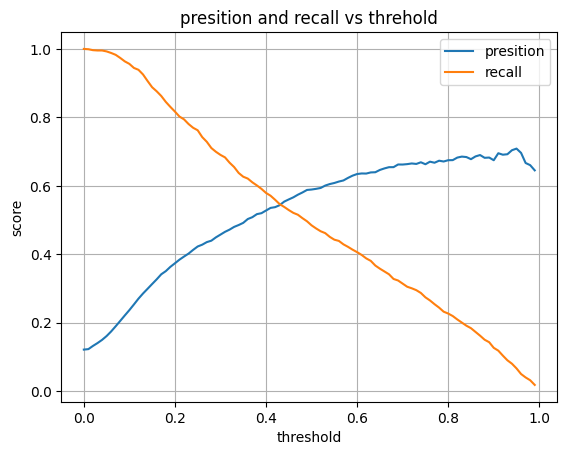

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(th_vector, presition_vector, label='presition')
plt.plot(th_vector, recall_vector, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('presition and recall vs threhold')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
abs_diff_pr_recall = np.abs(presition_vector - recall_vector)
min_index = abs_diff_pr_recall.argmin()
th_vector[min_index]

np.float64(0.43)

## Question 4

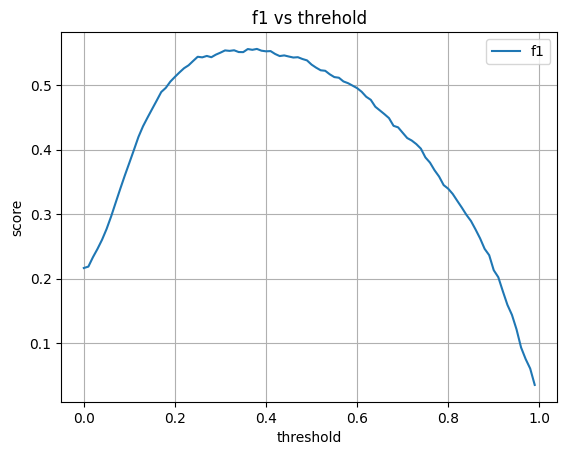

In [30]:
f1_vector = np.empty_like(th_vector)

for i, th in enumerate(th_vector):
    f1_vector[i] = 2 * presition_vector[i] * recall_vector[i] / (presition_vector[i] + recall_vector[i])
     

plt.figure()
plt.plot(th_vector, f1_vector, label='f1')
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('f1 vs threhold')
plt.grid(True)
plt.legend()
plt.show()


In [31]:
arg_max_f1 = np.argmax(f1_vector)

print("th_vector[arg_max_f1]:", th_vector[arg_max_f1])
print("f1_vector[arg_max_f1]:", f1_vector[arg_max_f1])

th_vector[arg_max_f1]: 0.38
f1_vector[arg_max_f1]: 0.5560235888795282


## Question 5

In [32]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores_vector = np.empty(5)
count_iterations = 0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train[TARGET_COLUMN]
    y_val = df_val[TARGET_COLUMN]

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_val[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)

    roc_auc_value = roc_auc_score(y_val, y_pred[:, 1])
    auc_scores_vector[count_iterations] = roc_auc_value
    count_iterations += 1

    print(f"for iteration {count_iterations} roc_auc_value: {roc_auc_value}")

std_dev = auc_scores_vector.std()
print(f"std_dev: {std_dev}")

for iteration 1 roc_auc_value: 0.8993733054494373
for iteration 2 roc_auc_value: 0.898944421423942
for iteration 3 roc_auc_value: 0.9112805043937209
for iteration 4 roc_auc_value: 0.9081388806828126
for iteration 5 roc_auc_value: 0.9119843456804715
std_dev: 0.005691215739889739


## Question 6

In [33]:
C_vector = [0.000001, 0.001, 1]
len_c_vector = len(C_vector)

N_SPLIT = 5
kfold = KFold(n_splits=N_SPLIT, shuffle=True, random_state=1)

auc_scores_matrix = np.empty((len_c_vector, N_SPLIT))

for i, c_value in enumerate(C_vector):

    count_iterations = 0

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train[TARGET_COLUMN]
        y_val = df_val[TARGET_COLUMN]

        dv = DictVectorizer(sparse=False)
        train_dict = df_train[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=c_value, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val[CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)

        roc_auc_value = roc_auc_score(y_val, y_pred[:, 1])
        auc_scores_matrix[i, count_iterations] = roc_auc_value
        count_iterations += 1

        print(f"for c value {c_value} for iteration {count_iterations} roc_auc_value: {roc_auc_value}")

    print()

for c value 1e-06 for iteration 1 roc_auc_value: 0.6847426813003405
for c value 1e-06 for iteration 2 roc_auc_value: 0.700093195088892
for c value 1e-06 for iteration 3 roc_auc_value: 0.7120471006278472
for c value 1e-06 for iteration 4 roc_auc_value: 0.7087058212547206
for c value 1e-06 for iteration 5 roc_auc_value: 0.7016341366114567

for c value 0.001 for iteration 1 roc_auc_value: 0.8486725085612328
for c value 0.001 for iteration 2 roc_auc_value: 0.8596876977929157
for c value 0.001 for iteration 3 roc_auc_value: 0.8642941782819902
for c value 0.001 for iteration 4 roc_auc_value: 0.8692410748726594
for c value 0.001 for iteration 5 roc_auc_value: 0.8638947784459449

for c value 1 for iteration 1 roc_auc_value: 0.8993733054494373
for c value 1 for iteration 2 roc_auc_value: 0.898944421423942
for c value 1 for iteration 3 roc_auc_value: 0.9112805043937209
for c value 1 for iteration 4 roc_auc_value: 0.9081388806828126
for c value 1 for iteration 5 roc_auc_value: 0.9119843456804715


In [34]:
std_values = auc_scores_matrix.std(axis=1)
argmin_std_index = std_values.argmin()

C_min = C_vector[argmin_std_index]
print(f"C_min: {C_min}")
print(f"std min: {std_values[argmin_std_index]}")

C_min: 1
std min: 0.005691215739889739
